In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis


In [2]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

In [3]:
# pickle_file = 'data/COX_DATA_FULL_LIVING.pkl'
pickle_file = 'data/COX_DATA_FULL_LIVING_EXPERIMENTAL.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

dataset.drop(['DIAG_KI', 'COD_KI'], axis=1, inplace=True)

In [4]:
yes_categorical=[
                "PRE_TX_TXFUS", 
                "GENDER",
                "ON_DIALYSIS", 
                "ETHCAT", 
                "ETHCAT_DON",
                'DIAB',
                'HCV_SEROSTATUS',  
                'LIV_DON_TY',
                "ABO_MAT", 
                'HBV_CORE', 
                
            ]
yes_numerical = [   
                # "SERUM_CREAT", # might be data leakage, as it is after the transplant
                "AGE", 
                "AGE_DON",
                "DIALYSIS_TIME",                
                "KI_CREAT_PREOP", # negative importance
                "NPKID", # negative importance
                "HGT_CM_CALC",  # negative importance
                "BMI_DON_CALC", # negative importance
                ]

In [5]:
dataset[yes_numerical] = dataset[yes_numerical].astype(float)

dataset[yes_numerical].dtypes

AGE               float64
AGE_DON           float64
DIALYSIS_TIME     float64
KI_CREAT_PREOP    float64
NPKID             float64
HGT_CM_CALC       float64
BMI_DON_CALC      float64
dtype: object

In [6]:
numeric_features = [x for x in yes_numerical if x != "PTIME" and x != "PSTATUS"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')) # maybe it's better to use not ignore
])

# Combine transformations for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, yes_numerical),
        ('cat', categorical_transformer, yes_categorical)
    ]
)

# Set up the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply preprocessing to X
# X = pipeline.fit_transform(dataset[yes_categorical + yes_numerical])

# For calculating feature importance
categorical_x = encode_categorical(dataset[yes_categorical])
numerical_x = standardize(dataset[yes_numerical])
X = pd.concat([numerical_x, categorical_x], axis=1)

survival_time = dataset["PTIME"].astype(np.float64)
event = dataset["PSTATUS"].astype(float).astype(bool)

y = Surv.from_arrays(event, survival_time, "Status", "Days")

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [8]:
X_train.shape

(42465, 45)

In [9]:
def evaluate_model(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    surv_fn = model.predict_survival_function(X_test, return_array=False)
    surv_prob = np.row_stack([fn(times) for fn in surv_fn])

    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    ibs = integrated_brier_score(y_train, y_test, surv_prob, times)
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, pred, times)

    print(f"Concordance Uno: {uno_concordance}")
    print(f"IBS: {ibs}")
    print(f"Mean AUC: {mean_auc}")

    return uno_concordance, ibs, mean_auc

In [10]:
lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

In [14]:
import pickle

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

with open('TrainedModels/GBSA_0.722_lr0.2_leaving_early_stopping.pkl', 'rb') as file:
    best_model = pickle.load(file)

Text(0, 0.5, 'time-dependent Brier Score')

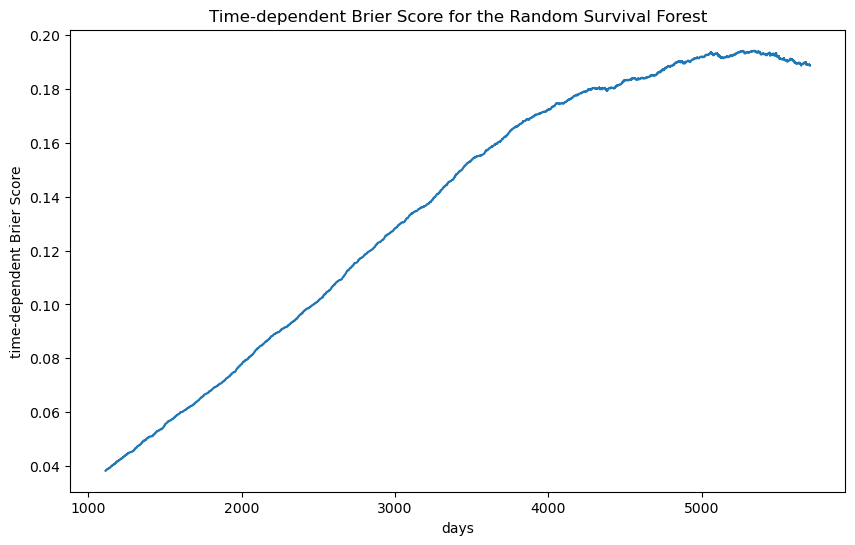

In [15]:
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score

surv_fn = best_model.predict_survival_function(X_test, return_array=False)

surv_prob = np.row_stack([fn(times) for fn in surv_fn])

bs = brier_score(y_train, y_test, surv_prob, times)

plt.figure(figsize=(10,6))
plt.plot(bs[0], bs[1], marker=",")
# plt.axhline(ibs, linestyle="--")
# plt.text(5, 0, "{model}", fontsize=12)
plt.title("Time-dependent Brier Score for the Random Survival Forest")
plt.xlabel("days")
plt.ylabel("time-dependent Brier Score")

In [18]:
import pickle

with open('pickle/brier/BS_GBSA_LIVING_FINAL.pickle', 'wb') as f:
    pickle.dump(bs, f)


In [19]:
lower, upper = np.percentile(y_train["Days"], [10, 90])
times = np.arange(lower, upper + 1)
cph_risk_scores = best_model.predict(X_test)
auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)

In [21]:
with open('pickle/AUC/AUC_GBSA_LIVING_FINAL.pickle', 'wb') as f:
    pickle.dump((times, auc, mean_auc), f)

# GBSA

In [ ]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.2, subsample=0.5, max_depth=4, random_state=0, verbose=1
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       60310.9849         200.4216          318.54m
         2       59766.1284         183.9330          325.38m
         3       59258.1937         169.2727          328.42m
         4       59235.4181         147.4785          328.83m
         5       59535.7240         137.2431          329.43m
         6       59711.0191         115.9507          329.51m
         7       59177.8172         105.2360          328.83m
         8       59633.4321          94.1630          328.32m
         9       59505.6870          86.5201          327.98m
        10       60226.6962          74.9082          327.74m
        20       59091.2426          26.8259          328.87m
        30       58583.0095          10.9151          324.92m
        40       58084.3328           5.7154          322.07m
        50       58496.4554           1.8910          320.23m
        60       57374.4080           0.2697          316.66m
       

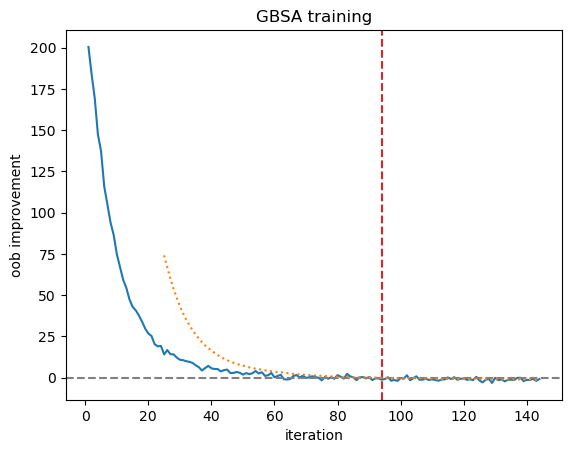

In [ ]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_, index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="oob improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")
ax.title.set_text("GBSA training")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")

In [ ]:
evaluate_model(est_early_stopping, X_test, y_test, y_train, times)

Concordance Uno: (0.7222418123930751, 13802892, 5352503, 2, 3954)
IBS: 0.13584495657113635
Mean AUC: 0.742727843953689


((0.7222418123930751, 13802892, 5352503, 2, 3954),
 0.13584495657113635,
 0.742727843953689)

In [ ]:
import pickle

# it is commented out to avoid saving the wrong model and overwriting the correct one
# pickle_file = 'TrainedModels/GBSA_0.722_lr0.2_leaving_early_stopping.pkl'

# with open(pickle_file, 'wb') as f:
#     pickle.dump(est_early_stopping, f)
